In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import sys
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader

from utils.ntu_dataset import NTUDataset
import utils.augmentations as augmentations
from utils.augmentations import Normalize3D
from utils.base_dataset import BaseDataset
from model.sttformer import Model
from utils.ntu_pipeline import NTU2Feeder

/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [2]:
action_classes = [
    'drink water', 'eat meal/snack', 'brushing teeth', 'brushing hair', 'drop', 'pickup', 'throw', 'sitting down',
    'standing up (from sitting position)', 'clapping', 'reading', 'writing', 'tear up paper', 'wear jacket',
    'take off jacket', 'wear a shoe', 'take off a shoe', 'wear on glasses', 'take off glasses', 'put on a hat/cap',
    'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something', 'reach into pocket', 'hopping (one foot jumping)',
    'jump up', 'make a phone call/answer phone', 'playing with phone/tablet', 'typing on a keyboard',
    'pointing to something with finger', 'taking a selfie', 'check time (from watch)', 'rub two hands together',
    'nod head/bow', 'shake head', 'wipe face', 'salute', 'put palms together', 'cross hands in front',
    'sneeze/cough', 'staggering', 'falling', 'touch head (headache)', 'touch chest (stomachache/heart pain)',
    'touch back (backache)', 'touch neck (neckache)', 'nausea or vomiting condition', 'use a fan (with hand or paper)/feeling warm',
    'punching/slapping other person', 'kicking other person', 'pushing other person', 'pat on back of other person',
    'point finger at the other person', 'hugging other person', 'giving something to other person', 'touch other person\'s pocket',
    'handshaking', 'walking towards each other', 'walking apart from each other'
]

In [17]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
ntu2feeder = NTU2Feeder(window_size=80)
pipeline = torchvision.transforms.Compose([augmentations.PreNormalize3D(),ntu2feeder])
augmentation = torchvision.transforms.Compose([augmentations.RandomRot(theta=0.2), augmentations.RandomScale(scale=0.2), augmentations.RandomGaussianNoise(sigma=0.005)])
strong_augmentation = torchvision.transforms.Compose([augmentations.RandomRot(theta=0.8), augmentations.RandomScale(scale=0.8), augmentations.RandomGaussianNoise(sigma=0.04)])
ntu_augmented_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_train', num_classes=60, multi_class=True, augmentation=augmentation, strong_augmentation=strong_augmentation)

In [5]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
ntu2feeder = NTU2Feeder(window_size=80)
pipeline = torchvision.transforms.Compose([augmentations.PreNormalize3D(),ntu2feeder])
ntu_normal_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_train', num_classes=60, multi_class=True, augmentation=None, strong_augmentation=None)

In [18]:
tmp_aug = ntu_augmented_dataset[350]
tmp_norm = ntu_normal_dataset[350]
print(list(tmp_aug.keys()))
print(list(tmp_norm.keys()))

['frame_dir', 'label', 'keypoint', 'total_frames', 'start_index', 'augment1', 'augment2', 'body_center', 'input', 'original']
['frame_dir', 'label', 'keypoint', 'total_frames', 'start_index', 'augment1', 'augment2', 'body_center', 'input', 'original']


In [7]:
print(tmp_aug['augment1'].shape)
print(tmp_aug['augment2'].shape)

torch.Size([3, 80, 25, 2])
torch.Size([3, 80, 25, 2])


torch.Size([3, 80, 25, 2])
torch.Size([3, 80, 25, 2])


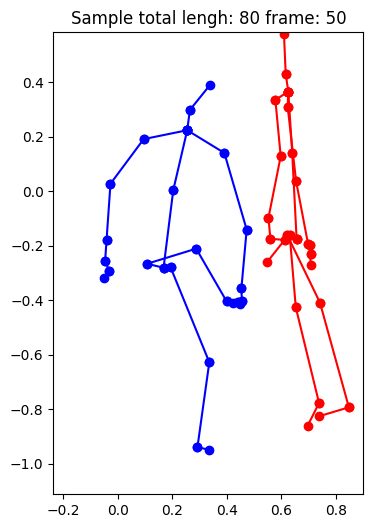

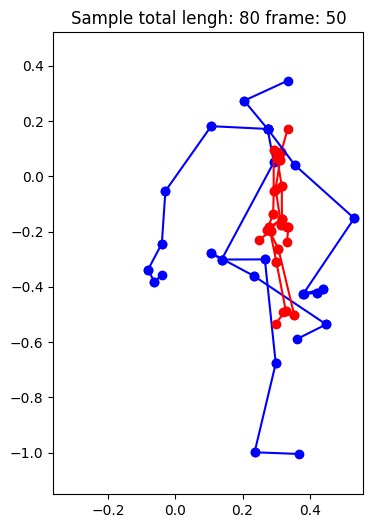

In [19]:
plot_tensor_skeleton(tmp_aug['augment1'], set_frame=50, all_subjects=True)
plot_tensor_skeleton(tmp_aug['augment2'], set_frame=50, all_subjects=True)

In [8]:
def plot_tensor_skeleton(tensor: torch.Tensor, set_frame: int=None, all_subjects: bool=False):
        """
        Take as input a tensor of shape (C, T, V, M)
        """
        ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
                (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
                (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
                (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
        print(tensor.shape)
        
        if set_frame is not None:
            if set_frame > tensor.shape[1]:
                raise ValueError(f"Frame value to high, total frame {tensor.shape[1]}")
            else:
                random_frame_idx = set_frame
        else:
            random_frame_idx = random.choice(range(tensor.shape[1]))

        tensor_reshaped = tensor.permute(3, 1, 2, 0)

        if all_subjects:
            x_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,2]

            x_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,0] 
            y_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,2]

            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint_0[i], x_keypoint_0[j]], [y_keypoint_0[i],y_keypoint_0[j]], c='b', marker='o')
                plt.plot([x_keypoint_1[i], x_keypoint_1[j]], [y_keypoint_1[i],y_keypoint_1[j]], c='r', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[:,:,:,0].numpy()), np.amax(tensor_reshaped[:,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[:,:,:,2].numpy()), np.amax(tensor_reshaped[:,:,:,2].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
        else:
            x_keypoint = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint = tensor_reshaped[0][random_frame_idx][:,2]
            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[0,:,:,0].numpy()), np.amax(tensor_reshaped[0,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[0,:,:,2].numpy()), np.amax(tensor_reshaped[0,:,:,2].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
    

In [15]:
output_device = 0 # GPU device

config = [[64,  64,  16], [64,  64,  16], 
           [64,  128, 32], [128, 128, 32],
           [128, 256, 64], [256, 256, 64], 
           [256, 256, 64], [256, 256, 64]]

sttformer_model = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=60,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config).cuda(output_device)

sttformer_model = nn.DataParallel(sttformer_model, device_ids=[output_device,output_device+1])

In [20]:
ntu_train_dataloader = DataLoader(dataset=ntu_augmented_dataset,
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               num_workers=os.cpu_count())

In [19]:
next(iter(ntu_train_dataloader))['augment1'].shape

torch.Size([64, 3, 80, 25, 2])

In [ ]:
### Training step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=output_device):
    train_loss, train_acc = 0, 0

    model.train()
    
    for batch, batch_item in enumerate(dataloader):
        X_view1 = batch_item['augment1']
        X_view2 = batch_item['augment2']
        # y = batch_item['label']
        with torch.no_grad():
            X_view1, X_view2 = X_view1.float().cuda(output_device), X_view2.float().cuda(output_device)
            y = y.float().cuda(output_device)
        
        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=0), dim=1)
        y_argmax = torch.argmax(y, dim=1)
        train_acc += (y_pred_class==y_argmax).sum().item()/len(y_pred)
    
    # Adjust metrics to get average los and accuracy 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc        